In [1]:
import pandas as pd
import censusdata
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sb

%matplotlib inline
%config InlineBackend.figure_format ='retina'

sharedFolder = '/work/group/egodat/reu23_clark/'
dataFolder = sharedFolder + 'data/'

In [2]:
gdf = pd.read_pickle(sharedFolder + "gdf2020.pkl")
gdf = gdf[['CBSA', 'NAME', 'metro', 'micro', 'liminal', 'geometry']]
gdf

,CBSA,NAME,metro,micro,liminal,geometry
0,10180,"Abilene, TX",False,False,False,"POLYGON ((-11148262.500 3832132.455, -11148249..."
1,10420,"Akron, OH",False,False,False,"POLYGON ((-9060481.928 5063847.837, -9060475.5..."
2,10500,"Albany, GA",False,False,False,"POLYGON ((-9400975.184 3713776.408, -9400980.6..."
3,10540,"Albany-Lebanon, OR",False,False,False,"POLYGON ((-13720236.776 5551262.937, -13720393..."
4,10580,"Albany-Schenectady-Troy, NY",False,False,False,"POLYGON ((-8247992.807 5305256.748, -8248085.6..."
...,...,...,...,...,...,...
921,49300,"Wooster, OH",False,False,False,"POLYGON ((-9089178.853 5010653.858, -9088979.1..."
922,49380,"Worthington, MN",False,True,False,"POLYGON ((-10627927.538 5441934.306, -10627791..."
923,49460,"Yankton, SD",False,True,False,"POLYGON ((-10855702.126 5337734.746, -10853435..."
924,49780,"Zanesville, OH",False,True,True,"POLYGON ((-9149881.580 4868949.855, -9149879.9..."


In [7]:
mig = gpd.GeoDataFrame(pd.read_pickle(dataFolder + '2010-2021_net_migration.pkl')).reset_index()

mig = mig.reset_index().rename(columns={
    'cbsa': 'CBSA', 'NATURALCHG2021': 'NATURALINC2021', 'RNATURALCHG2021': 'RNATURALINC2021'
}).drop(columns=[
    'STNAME', 'CTYNAME', 'CENSUS2010POP' #CENSUS2010POP is a string??
])

mig = pd.merge(mig, gdf, on='CBSA')
mig

,index,CBSA,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,...,RDEATH2021,RNATURALINC2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021,NAME,metro,micro,liminal,geometry
0,0,10100,40603,40721,40974,41591,42175,42250,42432,42821,...,9.670569,1.740910,0.918006,2.838459,3.756464,"Aberdeen, SD",False,True,False,"POLYGON ((-10989736.448 5659978.604, -10990063..."
1,1,10140,72800,72849,72374,71785,71059,70796,71027,71555,...,14.110526,-5.017949,-0.052407,18.709221,18.656814,"Aberdeen, WA",False,True,True,"POLYGON ((-13837615.681 5982098.516, -13837721..."
2,2,10180,165252,165590,166651,167483,167515,168408,169770,170087,...,12.488353,-2.679196,0.169742,14.518106,14.687848,"Abilene, TX",False,False,False,"POLYGON ((-11148262.500 3832132.455, -11148249..."
3,3,10220,37488,37594,37751,38064,38162,38292,38343,38499,...,14.428122,-0.996852,0.131165,2.964323,3.095488,"Ada, OK",False,True,True,"POLYGON ((-10790478.575 4120536.368, -10790479..."
4,4,10300,99898,99642,99370,99041,98850,98774,98432,98595,...,12.817278,-3.280012,0.312863,0.151385,0.464248,"Adrian, MI",False,True,True,"POLYGON ((-9391131.716 5145826.837, -9391131.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,922,49660,565782,564760,562339,558594,555998,553267,549114,544768,...,15.486454,-5.858467,0.137715,2.655956,2.793671,"Youngstown-Warren-Boardman, OH-PA",False,False,False,"POLYGON ((-9017133.666 5032154.477, -9017136.6..."
922,923,49700,166893,167087,166946,166923,167539,168248,169263,170689,...,8.931499,4.164057,0.046323,2.639904,2.686227,"Yuba City, CA",False,False,False,"POLYGON ((-13539095.212 4764106.072, -13539054..."
923,924,49740,195750,197148,202881,202520,202447,204064,205187,207162,...,11.423655,2.649316,1.341672,8.302809,9.644481,"Yuma, AZ",False,False,False,"POLYGON ((-12775445.758 3848066.261, -12775405..."
924,925,49780,86086,86213,86252,85803,85660,85918,86213,85958,...,13.256151,-2.095514,0.127352,2.558611,2.685962,"Zanesville, OH",False,True,True,"POLYGON ((-9149881.580 4868949.855, -9149879.9..."


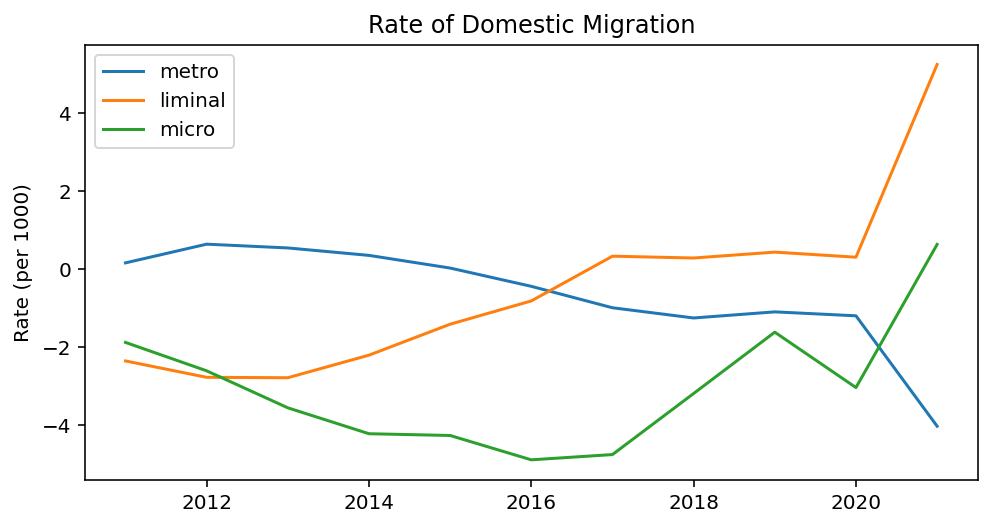

In [20]:
liminal = mig['liminal']
metro = mig['metro']
micro = mig['micro']
notLim = mig['micro'] & ~liminal

df = pd.DataFrame()
for year in range(2011, 2021 + 1):
    df.loc[year, 'metro'] =   mig[metro  ]['DOMESTICMIG%i' % year].sum() / (mig[metro  ]['POPESTIMATE%i' % (year-1)].sum() + mig[metro  ]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    df.loc[year, 'liminal'] = mig[liminal]['DOMESTICMIG%i' % year].sum() / (mig[liminal]['POPESTIMATE%i' % (year-1)].sum() + mig[liminal]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    df.loc[year, 'micro'] =   mig[notLim ]['DOMESTICMIG%i' % year].sum() / (mig[notLim ]['POPESTIMATE%i' % (year-1)].sum() + mig[notLim ]['POPESTIMATE%i' % year].sum()) * 2 * 1000

df.plot(figsize=(8, 4));
plt.ylabel("Rate (per 1000)")
plt.title("Rate of Domestic Migration");

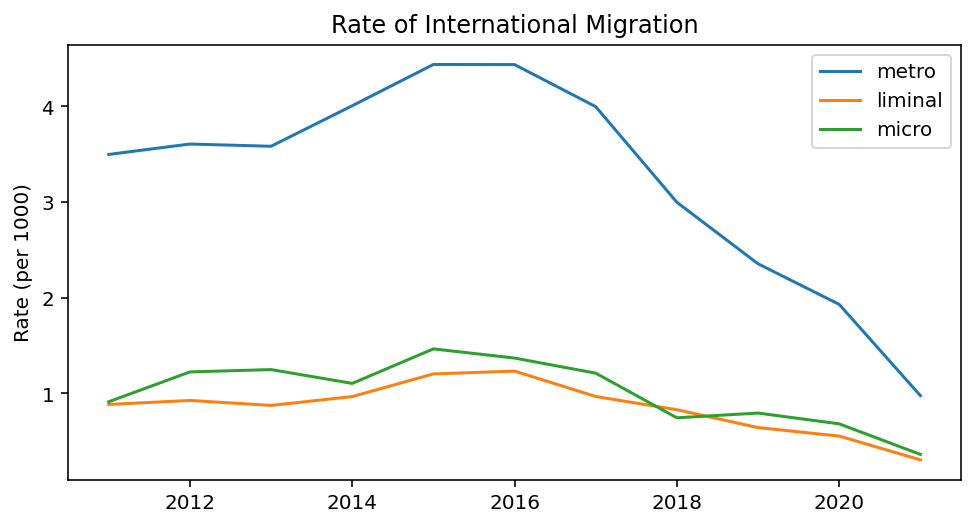

In [22]:
liminal = mig['liminal']
metro = mig['metro']
micro = mig['micro']
notLim = mig['micro'] & ~liminal

df = pd.DataFrame()
for year in range(2011, 2021 + 1):
    df.loc[year, 'metro'] =   mig[metro  ]['INTERNATIONALMIG%i' % year].sum() / (mig[metro  ]['POPESTIMATE%i' % (year-1)].sum() + mig[metro  ]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    df.loc[year, 'liminal'] = mig[liminal]['INTERNATIONALMIG%i' % year].sum() / (mig[liminal]['POPESTIMATE%i' % (year-1)].sum() + mig[liminal]['POPESTIMATE%i' % year].sum()) * 2 * 1000
    df.loc[year, 'micro'] =   mig[notLim ]['INTERNATIONALMIG%i' % year].sum() / (mig[notLim ]['POPESTIMATE%i' % (year-1)].sum() + mig[notLim ]['POPESTIMATE%i' % year].sum()) * 2 * 1000

df.plot(figsize=(8, 4));
plt.ylabel("Rate (per 1000)")
plt.title("Rate of International Migration");

In [55]:
mig['RDOMESTICMIG2021w'] = mig['DOMESTICMIG2021'] / (mig['POPESTIMATE2020'] + mig['POPESTIMATE2021']) * 2 * 1000
mig[liminal].sort_values('RDOMESTICMIG2021w')[['NAME', 'CBSA', 'DOMESTICMIG2021', 'RDOMESTICMIG2021w', 'POPESTIMATE2021']]

,NAME,CBSA,DOMESTICMIG2021,RDOMESTICMIG2021w,POPESTIMATE2021
165,"Clarksdale, MS",17260,-408,-19.257092,20810
679,"Port Lavaca, TX",38920,-336,-16.499705,19727
293,"Forrest City, AR",22620,-318,-13.411780,22739
262,"Enid, OK",21420,-756,-12.313205,61926
768,"Selma, AL",42820,-432,-11.720499,37619
...,...,...,...,...,...
686,"Prineville, OR",39260,889,34.969711,25739
716,"Rockport, TX",40530,849,35.137820,24510
327,"Granbury, TX",24180,2632,41.205802,64222
639,"Pahrump, NV",37220,2144,42.244641,53450
